# Introduction and Background

In this notebook, we introduce kernel-based versions of the models covered in the [Linear Methods](1_LinearMethods.ipynb) and [PCovR](2_PrincipalCovariatesRegression.ipynb) notebooks.

As always, for each model, we first go step-by-step through the derivation, with equations, embedded links, and citations supplied where useful. Second, we will employ a "Sklearn/Skcosmo Class" for the models, which can be found in the skcosmo/sklearn mudule and contains all necessary functions.

**Note**: To display values of variables in the markdown cells, you should [enable the jupyter contrib nbextension](https://stackoverflow.com/questions/52812231/print-variable-in-jupyter-notebook-markdown-cell-python).

In [1]:
#!/usr/bin/env python3

import sys

# Maths things
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Local Utilities for Notebook
sys.path.append("../")
from utilities.general import load_variables, sorted_eig, get_stats
from utilities.plotting import (
    plot_projection,
    plot_regression,
    check_mirrors,
    get_cmaps,
    table_from_dict,
)
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from functools import partial

from skmatter.decomposition import KernelPCovR
from skmatter.preprocessing import KernelNormalizer

cmaps = get_cmaps()
plt.style.use("../utilities/kernel_pcovr.mplstyle")
dbl_fig = (2 * plt.rcParams["figure.figsize"][0], plt.rcParams["figure.figsize"][1])

First, we must load the data. For a step-by-step explanation of this, please see [Importing Data](X_ImportingData.ipynb). As mentioned in the [foreword notebook](0_Foreword.ipynb), pre-computed features should be downloaded from [here](https://www.dropbox.com/s/itokckbbkvxaqsk/precomputed.npz?dl=0) and the file `precomputed.npz` should be copied to the `datasets/` folder.

In [2]:
var_dict = load_variables()
locals().update(var_dict)

Shape of Input Data is  (1362, 2520) .
Taking a subsampling of  200 features
Splitting Data Set


# Constructing Kernels

## The Kernel Trick

Many kernel methods are similar to linear methods,
except that we take advantage of the [**kernel trick**](https://en.wikipedia.org/wiki/Kernel_method#Mathematics:_the_kernel_trick) in order to 
introduce a non-linear transformation of the feature space.

The kernel trick consists in introducing a [**positive definite**](https://en.wikipedia.org/wiki/Positive-definite_kernel) function of pairs of samples, $ k(\mathbf{x}, \mathbf{x}^{\prime})$, that defines implicitly a higher (possibly infinite) dimensional feature space, in which one can apply linear analysis methods. 

There are [many](https://en.wikipedia.org/wiki/Positive-definite_kernel#Examples_of_p.d._kernels) positive definite kernels. Common kernels are the linear (dot product) kernel,
\begin{equation}
    k(\mathbf{x}, \mathbf{x}^{\prime}) = \mathbf{x}^T \mathbf{x},
\end{equation}
and the Gaussian kernel,
\begin{equation}
    k(\mathbf{x}, \mathbf{x}^{\prime}) = \exp{\left(-\gamma\lVert \mathbf{x} - \mathbf{x}^{\prime}\rVert^2\right)}.
\end{equation}

In this notebook we use the gaussian kernel (```rbf_kernel(XA, XB, gamma=1.0)```), however, we have also included the linear kernel function (```linear_kernel(XA, XB)```) in ```sklearn```. You can check rather easily that if you use a linear kernel all of the kernel methods reduce explicitly to linear regression or principal component analysis in the original feature space.

In [3]:
# Changing the kernels in this cell will change them throughout the notebook tutorial.
# The function variable designates the kernel function to use throughout the notebook.
# The string variable is used to pass to the utility classes.
kernel_params = {"kernel": "rbf", "gamma": 1.0}
kernel_func = partial(rbf_kernel, gamma=1.0)
kernel_type = "gaussian"

The [representer theorem](https://en.wikipedia.org/wiki/Representer_theorem) guarantees that if the kernel is a positive definite function (both these two examples are) there is a Hilbert space with elements $\phi(\mathbf{x})$ whose dot product reproduces the kernel, i.e.

\begin{equation}
    k(\mathbf{x}, \mathbf{x}^{\prime}) = \phi(\mathbf{x})^T\phi(\mathbf{x}^{\prime}).
\end{equation}

This Hilbert space is known as the [**reproducing kernel Hilbert space**](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space), or RKHS. If one builds a kernel matrix $\mathbf{K}$ whose elements contain the kernel computed between the corresponding pair of samples, 
For simple kernels, such as the linear kernel shown above, the RKHS is intuitive: $\phi(\mathbf{x}) = \mathbf{x}$.
However, for even slightly more complex kernel functions, the RKHS may be infinitely dimensional, such as the [RBF kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel).
If one builds a kernel matrix $\mathbf{K}$ whose elements contain the kernel computed between the corresponding pair of samples, 

\begin{equation}
    K_{ij} = k(\mathbf{x}_i, \mathbf{x}_j)
\end{equation}

the formal relation with the reproducing features can be written in a matrix notation

\begin{equation}
\quad \mathbf{K} = \mathbf{\Phi_X\Phi_X^T}.
\end{equation}

$\mathbf{\Phi_X}$ indicates a matrix that holds the values of the RKHS features for each sample in $\mathbf{X}$, which means that $\mathbf{X}$and $\mathbf{\Phi_X}$ have the same number of samples, but different numbers of features. To simplify the notation, in this notebook we drop the $\mathbf{X}$ subscript and refer to this matrix simply as $\mathbf{\Phi}$.

In [4]:
K_train_raw = kernel_func(X_train, X_train)

It is important to realize that even if in general $\phi(\mathbf{x})$ is not known, _for a given data set_ the representer theorem provides an explicit construction for an approximation of the RKHS features. The construction is very closely related to the KPCA method that we discuss below. 

Start by writing an eigendecomposition of the kernel matrix, 

\begin{equation}
    \mathbf{K} = \mathbf{U_K} \mathbf{\Lambda_K} \mathbf{U_K}^T.
\end{equation}

If one defines 
\begin{equation}
\mathbf{\Phi} =  \mathbf{U_K} \mathbf{\Lambda_K}^{1/2} = \mathbf{K} \mathbf{U_K} \mathbf{\Lambda_K}^{-1/2}
\end{equation}
one sees that $\mathbf{\Phi}\mathbf{\Phi}^T = \mathbf{K}$: the eigenvectors of the kernel matrix make it possible to construct a set of features whose scalar product reproduces exactly the values of the kernel for the dataset. 

The second equality is important because it provides a recipe to build an _approximate_ set of RKHS features for a _new_ set of points. If $\mathbf{K}_{NN}$ indicates the kernel matrix for the train set, and the matrix $\mathbf{K}_{N'N}$ contains the kernels between some new (e.g. test-set) samples and the train samples, which means the size of $\mathbf{K}_{N'N}$  is $n_{new\ samples}\times n_{train\ sample}$,  one can compute 
\begin{equation}
\mathbf{\Phi}_{N'N} = \mathbf{K}_{N'N} \mathbf{U} \mathbf{\Lambda}^{-1/2},
\end{equation}
where $\mathbf{U}$ and $\mathbf{\Lambda}$ refer to the eigendecomposition of the square $\mathbf{K}_{NN}$.
Then, $\mathbf{\Phi}_{N'N}$ is a matrix whose entries approximate the RKHS features for the new set of points. 

In [5]:
v_K, U_K = np.linalg.eigh(K_train_raw)

# U_K/v_K are already sorted, but in *increasing* order, so reverse them
U_K = np.flip(U_K, axis=1)
v_K = np.flip(v_K, axis=0)

U_K = U_K[:, v_K > 0]
v_K = v_K[v_K > 0]

Phi = U_K @ np.diag(np.sqrt(v_K))

print(np.linalg.norm((K_train_raw - Phi @ Phi.T)))

6.631034350036693e-13


## Kernel Centering

Just as it is often convenient to center features for linear methods, it is often beneficial to work with kernels that are also "centered". Centering a kernel can be understood in terms of centering of the associated RKHS features.  

Let us first introduce the centering matrix $\mathbf{1}_{N'N}$, which is just is a $N'\times N$ matrix for which each element takes value $1/N$. 

Using the expression above for $\mathbf{\Phi}$, one can compute 

\begin{equation}
\bar{\mathbf{\Phi}}_{N'N} = \mathbf{1}_{N'N} \mathbf{K}_{NN} \mathbf{U} \mathbf{\Lambda}^{-1/2}
\end{equation}

A similar centering matrix can be built for $\mathbf{\Phi}_{NN}$

\begin{equation}
\bar{\mathbf{\Phi}}_{NN} = \mathbf{1}_{NN} \mathbf{K}_{NN} \mathbf{U} \mathbf{\Lambda}^{-1/2}
\end{equation}

The centered kernel $\tilde{\mathbf{K}}_{N'N}$ reads

\begin{equation}
\tilde{\mathbf{K}}_{N'N} = (\mathbf{\Phi}_{N'N} - \bar{\mathbf{\Phi}}_{N'N})(\mathbf{\Phi}_{NN}-\bar{\mathbf{\Phi}}_{NN})^T = 
\mathbf{K}_{N'N} -  \mathbf{1}_{N'N} \mathbf{K}_{NN} -  \mathbf{K}_{N'N}\mathbf{1}_{NN}
+ \mathbf{1}_{N'N} \mathbf{K}_{NN} \mathbf{1}_{NN}.
\end{equation}

which can be computed without the need of ever evaluating explicitly the RKHS features.
This is a common pattern in kernel methods: RKHS features allow casting problems in a linear
language, but eventually the linear problem can yield an equation in which one only needs to evaluate the kernel function.

In this notebook, we center the kernels, which can be done with a utility function

In [6]:
k_centerer = KernelNormalizer()
K_train = k_centerer.fit_transform(K_train_raw)
K_scale = k_centerer.scale_

## The Testing Set Kernel

For new data, we must generate a new kernel. Notice that a kernel takes *two* sets of data as arguments, one of which can be our testing $\mathbf{X}_{N'}$ and the other the training $\mathbf{X}_N$. This contains the kernels computed between all of the test set samples $N'$ and the train set samples $N$. This can be computed as 

In [7]:
K_test = kernel_func(X_test, X_train)

We center with the training kernel as reference, as discussed above

In [8]:
# centering relative to the approximate RHKS defined by
# the training kernel matrix can be achieved specifying
# K_train as the reference kernel matrix

K_test = k_centerer.transform(K_test)

# Kernel PCA (KPCA)

In [kernel principal component analysis](https://en.wikipedia.org/wiki/Kernel_principal_component_analysis)
(KPCA) we take advantage of the kernel in order to 
introduce a non-linear transformation of the feature space 
[(Scholkopf 1996)](http://www.face-rec.org/algorithms/Kernel/kernelPCA_scholkopf.pdf), 
[(Scholkopf 1998)](http://www.doi.org/10.1162/089976698300017467), and then proceed to single out the largest-variance directions in RKHS. 

With the linear (dot product) kernel, performing KPCA with a linear kernel is equivalent to performing standard PCA.

## The Principal Components

KPCA proceeds analogously to PCA. First, the eigenvalues and eigenvectors of $\mathbf{K}$ are computed:
\begin{equation}
    \mathbf{K} = \mathbf{U_K} \mathbf{\Lambda_K} \mathbf{U_K}^T
\end{equation}

In [9]:
v_K, U_K = np.linalg.eigh(K_train)

# U_K/v_K are already sorted, but in *increasing* order, so reverse them
U_K = np.flip(U_K, axis=1)
v_K = np.flip(v_K, axis=0)

U_K = U_K[:, v_K > 0]
v_K = v_K[v_K > 0]

## The KPCA Projection

The KPCA projection may then be computed taking the first $n_{PCA}$ components 
\begin{equation}
\mathbf{T}=\mathbf{\hat{U}_K}\mathbf{\hat{\Lambda}_K}^{1/2} = \mathbf{\hat{U}_K}\mathbf{\hat{\Lambda}_K} (\mathbf{\hat{U}_K}^T\mathbf{\hat{U}_K}) \mathbf{\hat{\Lambda}_K}^{-1/2} = \mathbf{K} \mathbf{\hat{U}_K} \mathbf{\hat{\Lambda}_K}^{-1/2}
\end{equation}
\begin{equation}
    \mathbf{T} = \mathbf{K}\mathbf{P}_{KT} = \mathbf{K} \mathbf{\hat{U}_K} \mathbf{\hat{\Lambda}_K}^{-1/2}.
\end{equation}

**Remember that in PCA, the projection $\mathbf{T} = \mathbf{X}\mathbf{U}_C$. So why the factor of $\mathbf{\Lambda}_K^{-1/2}$?**

The eigenvectors of $\mathbf{K} = \mathbf{\Phi}\mathbf{\Phi}^T$ are in fact analogous to the eigenvectors of the Gram matrix $\mathbf{X}\mathbf{X}^T$ and thereby related to those of the covariance $\mathbf{C} = \mathbf{X}^T\mathbf{X} = \mathbf{U}_C \mathbf{\Lambda}_C \mathbf{U}_C^T$ by $\mathbf{X}\mathbf{U_C}$, which is not normalized. In essence, the $\mathbf{\Lambda}_K^{-1/2}$ factor serves to normalize our projection matrix. [(Tipping 2001)](https://papers.nips.cc/paper/1791-sparse-kernel-principal-component-analysis.pdf) 

Note also that the KPCA latent space corresponds to the highest-variance components in the RKHS: if one does not truncate the latent space, $\mathbf{T}=\mathbf{\Phi}$

In [10]:
n_PC = 2

In [11]:
PKT = U_K[:, :n_PC] @ np.diagflat(1.0 / np.sqrt(v_K[0:n_PC]))

The expression for the testing data is then identical to that for the projection of the train set:
\begin{equation}
    \mathbf{T} = \mathbf{K}_{N'N} \mathbf{P}_{KT}
\end{equation}
$\mathbf{P}_{KT}$ is the projection obtained during training, while the $\mathbf{K}_{N'N}$ indicates the kernel between the test set and the training points.

In [12]:
T_KPCA_train = K_train @ PKT
T_KPCA_test = K_test @ PKT

**Note**: if we used a linear kernel, the projection would be identical to the PCA projection (modulo reflection, since the sign of the eigenvectors is not defined), and it would likewise correspond to the Classical MDS solution.

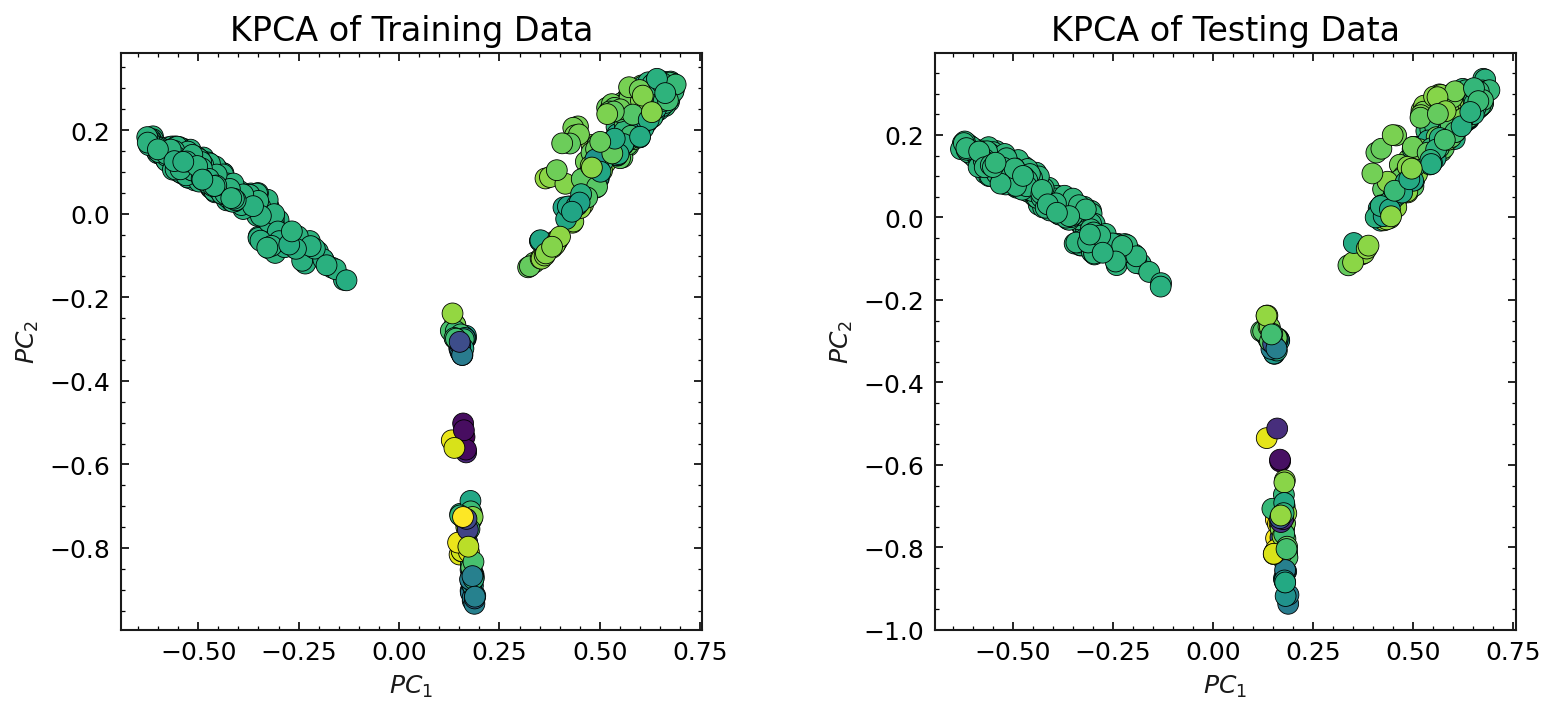

In [13]:
fig, axes = plt.subplots(1, 2, figsize=dbl_fig)
plot_projection(
    Y_train, T_KPCA_train, fig=fig, ax=axes[0], title="KPCA of Training Data", **cmaps
)
plot_projection(
    Y_test, T_KPCA_test, fig=fig, ax=axes[1], title="KPCA of Testing Data", **cmaps
)
fig.subplots_adjust(wspace=0.4)

Even though this is not done very often (because the kernel acts in a different space than the original feature space) it is possible to reconstruct an approximation of the feature vector based on the KPCA latent space. Consider this like "predicting" $\mathbf{X}$, similar to predicting $\mathbf{Y}$ in linear regression. The projection matrix $\mathbf{P}_{TX}$ corresponds to the least-square weights
    
\begin{equation}    
\mathbf{P}_{TX} = (\mathbf{T}\mathbf{T}^T)^{-1}\mathbf{T}^T \mathbf{X} =  \mathbf{\hat{\Lambda}}_K^{-1} \mathbf{T}^T \mathbf{X}
\end{equation}

Where the factor of $\mathbf{\Lambda_K}^{-1}$ arises from the fact that
$\mathbf{T}^T\mathbf{T}=
\mathbf{\Lambda_K}^{-1/2}\mathbf{U_K}^T\mathbf{K}^T\mathbf{K}\mathbf{U_K}\mathbf{\Lambda_K}^{-1/2}=
\mathbf{\Lambda_K}^{1/2}\mathbf{U_K}^T\mathbf{U_K}\mathbf{\Lambda_K}^{1/2}=
\mathbf{\Lambda_K}$.

In [14]:
PTX = np.diagflat(1 / ((v_K[:n_PC]))) @ T_KPCA_train.T @ X_train

Xr_train = T_KPCA_train @ PTX
Xr_test = T_KPCA_test @ PTX

The KPCA projection approximates the kernel matrix, so one can check for convergence using the [Frobenius norm](https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm).

In [15]:
K_approx_train = T_KPCA_train @ T_KPCA_train.T

K_test_test = kernel_func(X_test, X_test)
K_test_test = k_centerer.transform(K_test_test)
K_approx_test = T_KPCA_test @ T_KPCA_test.T

table_from_dict(
    [
        get_stats(
            x=X_train,
            xr=Xr_train,
            y=Y_train,
            t=T_KPCA_train,
            k=K_train,
            kapprox=K_approx_train,
        ),
        get_stats(
            x=X_test,
            xr=Xr_test,
            y=Y_test,
            t=T_KPCA_test,
            k=K_test_test,
            kapprox=K_approx_test,
        ),
    ],
    headers=["Training", "Testing"],
    title="KPCA",
)

<center><b> KPCA </b></center><br>                            <center><table><tr><th></th><th><center>Training</center></th><th><center>Testing</center></th></tr><td> Dataset Variance<br>$\sigma_X^2$ </td>                                                <td> 1 </td><td> 0.992388 </td></tr><tr><td> Projection Variance<br>$\sigma_T^2$ </td>                                                <td> 0.311739 </td><td> 0.307916 </td></tr><tr><td> Residual Variance<br>$\sigma_X^2 - \sigma_T^2$ </td>                                                <td> 0.688261 </td><td> 0.684472 </td></tr><tr><td> $\ell_{proj}$ </td>                                                <td> 0.493645 </td><td> 0.489431 </td></tr><tr><td> $\ell_{gram}$ </td>                                                <td> 0.196435 </td><td> 0.38091 </td></tr></table></center>

# Kernel Ridge Regression (KRR)

## Finding the KRR Weights
Just as in KPCA, in kernel ridge regression (KRR) we can use the kernel trick to make property predictions [(Saunders 1998)](https://eprints.soton.ac.uk/258942/1/Dualrr_ICML98.pdf). In KRR, the model takes the form
\begin{equation}
    \hat{\mathbf{Y}}_{KRR} = \mathbf{K} \mathbf{P}_{KY},
\end{equation}

where $\mathbf{P}_{KY}$ is a vector of regression weights. The regression weights can be computed using

\begin{equation}
    \mathbf{P}_{KY} = \left( \mathbf{K} + \lambda \mathbf{I} \right)^{-1}\mathbf{Y}
\end{equation}

where $\lambda$ is the regularization parameter 
[(Girosi 1995)](https://pdfs.semanticscholar.org/96af/5da062cee7ce50fc0624654c61363506772b.pdf),
[(Smola 2000)](https://pdfs.semanticscholar.org/dd09/78a594290f6dc530e65983d79a056874185c.pdf), 
[(Welling)](https://www.ics.uci.edu/~welling/classnotes/papers_class/Kernel-Ridge.pdf). This parameter can be set to some small fraction of the maximum eigenvalue $\lambda_{max}$ of $\mathbf{K}$, e.g., $\lambda = 10^{-16}\lambda_{max}$, or it can be determined through cross-validation.

In [16]:
lambda_max = np.amax(np.linalg.eigvalsh(K_train))
regularization = 1e-4
lambda_reg = lambda_max * regularization

PKY_krr = np.linalg.solve(K_train + lambda_reg * np.eye(n_train), Y_train)

Our regularization is {{regularization*lambda_max}}.

We then predict our properties using the training and testing kernels.

<Axes: title={'center': 'Kernel Ridge Regression: Testing Set'}, xlabel='$Y$', ylabel='$\\hat{Y}$'>

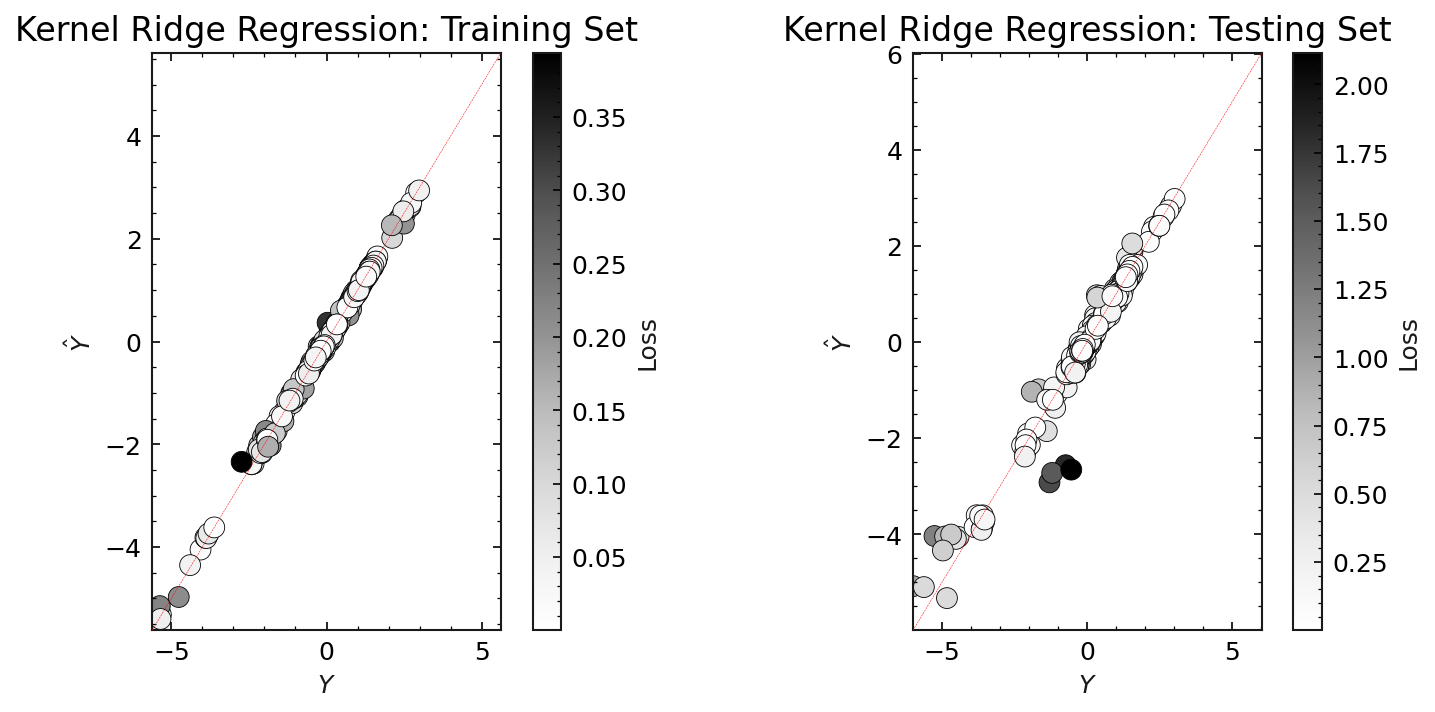

In [17]:
Y_krr_train = K_train @ PKY_krr
Y_krr_test = K_test @ PKY_krr

fig, axes = plt.subplots(1, 2, figsize=dbl_fig)

plot_regression(
    Y_train[:, 0],
    Y_krr_train[:, 0],
    title="Kernel Ridge Regression: Training Set",
    fig=fig,
    ax=axes[0],
    **cmaps
)
plot_regression(
    Y_test[:, 0],
    Y_krr_test[:, 0],
    title="Kernel Ridge Regression: Testing Set",
    fig=fig,
    ax=axes[1],
    **cmaps
)

## KRR as regression in RKHS

It is instructive to see how KRR is equivalent to ridge regression in RKHS features. In other words, the equation for ridge regression is equivalent to the equation for _kernel_ ridge regression when $\mathbf{X}$ is replaced with $\mathbf{\Phi}$.

\begin{equation}
    \hat{\mathbf{Y}}_{KRR} = \mathbf{\Phi} (\mathbf{\Phi}^T\mathbf{\Phi} 
      + \lambda \mathbf{I})^{-1} \mathbf{\Phi}^T \mathbf{Y} =
   \mathbf{\Phi} \mathbf{\Phi}^T   (\mathbf{\Phi}\mathbf{\Phi}^T
      + \lambda \mathbf{I})^{-1} \mathbf{Y} = \mathbf{K} (\mathbf{K}+\lambda \mathbf{I})^{-1} \mathbf{Y}
\end{equation}

where the second step can be proven through a Taylor expansion, where any function $f(A^T A) * A^T$ can be rewritten as $A^T*f(A A^T)$ by expanding it in the form $\sum_k c_k (A^T A)^k A^T  = A^T \sum_k c_k (A A^T)^k$.

<!---
omes from the relation
\begin{equation}
\left(\mathbf{B}^T\mathbf{RB} + \mathbf{P}^{-1}\right)^{-1}\mathbf{B}^T\mathbf{R}^{-1} = \mathbf{B}^T \left(\mathbf{B}\mathbf{P}\mathbf{B}^T + \mathbf{R}\right)
\end{equation}
whenever $\mathbf{P}$ and $\mathbf{R}$ are positive definite. Here, because $\mathbf{B} = \mathbf{\Phi}$, $\mathbf{P} = \mathbf{I}$ and $\mathbf{R} = \lambda \mathbf{I}$, the relation holds. [(Matrix Cookbook)](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf), [(Welling)](https://www.ics.uci.edu/~welling/classnotes/papers_class/Kernel-Ridge.pdf)
--->

## Error and Loss

Here our loss function is:

\begin{equation}
\ell = \left\lVert \mathbf{Y} - \mathbf{K}\mathbf{P}_{KY}\right\rVert^2
\end{equation}

which we can compare to that of ridge regression. Note how the additional flexibility afforded by the non-linear kernel halves the MSE. By reducing the regularization, one could reduce the train set error essentially to zero: in fact, the best regularization needs to be determined by cross-validation, or by using an external test set. 

In [18]:
lr = Ridge(alpha=regularization)

lr.fit(X_train, Y_train)
Y_lr = lr.predict(X_test)

table_from_dict([get_stats(x=X_test, 
                           yp=Y_lr,
                           y=Y_test, 
                           ), 
                 get_stats(x=X_test, 
                           yp=Y_krr_test,
                           y=Y_test, 
                           k=K_test)], 
                 headers = ["LR", "KRR"]
               )

TypeError: solve() got an unexpected keyword argument 'sym_pos'

## Choosing a Regularization Parameter

Similar to in linear/ridge regression, including some regularization is equivalent to introducing a $\mathcal{L}^2$ penalty in the loss, associated to $\left\lVert \mathbf{P}_{KY} \right\rVert^2$. Here we express it as a fraction of the maximum eigenvalue. While the regularization is used here just to avoid overfitting, it can also be interpreted -- as it is done in the context of Gaussian process regression -- as a measure of the level of noise that is present in the training data.

In [ ]:
regularizations = np.linspace(-10, -2, 24)
krrs = [KernelRidge(alpha=10 ** i, **kernel_params) for i in regularizations]

for k in krrs:
    k.fit(X=K_train, y=Y_train)

In [ ]:
ell = np.array(
    [
        np.linalg.norm(Y_test - k.predict(K_test)) ** 2.0
        / np.linalg.norm(Y_test) ** 2.0
        for k in krrs
    ]
)
best_regularization = 10 ** regularizations[ell.argmin()]

Even small regularizations lead to an increase in accuracy for predicting out-of-sample data. The best regularization here is {{round(best_regularization, 8)}}.

In [ ]:
plt.semilogx(10 ** regularizations, ell, marker="o", zorder=-1)
plt.scatter(
    best_regularization,
    min(ell),
    marker="o",
    color="r",
)

plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\ell$")

plt.title(r"Effect of $\lambda$ on $\ell$ for Kernel Ridge Regression")

plt.show()

# Kernel PCovR 

## Derivation of KernelPCovR
Formulating a kernelized version of PCovR is surprisingly simple. One just needs to write formally the expressions using the RKHS features in lieu of the linear features, and combine them into a kernel matrix to obtain the final expression.

As an important reminder, $\tilde{\mathbf{K}}$ represents the modified Gram matrix used in PCovR, given by

\begin{equation}
    \tilde{\mathbf{K}} = \alpha \mathbf{XX}^T
    + (1 - \alpha) \hat{\mathbf{Y}} \hat{\mathbf{Y}}^T,
\end{equation}

versus $\mathbf{K}$, which is our kernel matrix.

To construct a PCovR based upon the kernel matrix, we first need to use the approximate $\hat{\mathbf{Y}}$ obtained from (possibly regularized) KRR:

\begin{equation}
\hat{\mathbf{Y}} = \mathbf{K}\left(\mathbf{K}+\mathbf{I}\lambda\right)^{-1}\mathbf{Y},
\end{equation} 

and to substitute $\mathbf{K} = \mathbf{\Phi \Phi}^T$ for $ \mathbf{XX}^T$. 

We choose to normalize our kernel matrix dividing by the factor  $\operatorname{Tr}(\mathbf{K})/N$, so as to obtain a similar balancing of the LR and PCA parts of the loss as is used for linear PCovR. Thus we finally get

\begin{equation}
    \tilde{\mathbf{K}} = \alpha \frac{\mathbf{K}} {\operatorname{Tr}(\mathbf{K})/N} 
    + (1 - \alpha) \hat{\mathbf{Y}} \hat{\mathbf{Y}}^T.
\end{equation}

In [ ]:
alpha = 0.5

regularization = 1e-12

krr = KernelRidge(alpha=regularization, **kernel_params)
krr.fit(K_train, Y_train)
Yhat_train = krr.predict(K_train).reshape(-1, Y.shape[-1])
PKY = krr.dual_coef_
K_pca = K_train / (np.trace(K_train) / n_train)
K_lr = Yhat_train @ Yhat_train.T

Kt = (alpha * K_pca) + (1.0 - alpha) * K_lr

## Projecting into Latent Space

The projection can be obtained as in the linear PCovR case, combining eigenvalues and eigenvectors of $\tilde{\mathbf{K}}$

\begin{equation}
\mathbf{T} = \mathbf{K}\mathbf{P}_{KT} = \tilde{\mathbf{K}}\mathbf{\hat{U}_{\tilde{\mathbf{K}}}}\mathbf{\Lambda_{\tilde{\mathbf{K}}}}^{-1/2}
\end{equation}

In [ ]:
v_Kt, U_Kt= np.linalg.eigh(Kt)

# U_K/v_Ktare already sorted, but in *increasing* order, so reverse them
U_Kt= np.flip(U_Kt, axis=1)
v_Kt= np.flip(v_Kt, axis=0)

U_Kt= U_Kt[:,v_Kt>0]
v_Kt= v_Kt[v_Kt>0]

# note that Kt might have a large null space
print("Size {} vs {}".format(len(v_Kt),len(Kt)))

T = Kt @ U_Kt[:, :n_PC] @ np.diagflat(1.0/np.sqrt(v_Kt[:n_PC]))

Given each portion of $\tilde{\mathbf{K}}$ contains a factor of $\mathbf{K}$

\begin{equation}
\mathbf{\tilde{K}} = \left(\alpha \frac{\mathbf{K}} {\operatorname{Tr}(\mathbf{K})/N} + (1 - \alpha)
\mathbf{K}\left(\mathbf{K}+\mathbf{I}\lambda\right)^{-1}\mathbf{YY}^T \left(\mathbf{K}+\mathbf{I}\lambda\right)^{-1} \mathbf{K}
\right)
\end{equation}

We can find our projector by dividing $\tilde{\mathbf{K}}\mathbf{\hat{U}_{\tilde{\mathbf{K}}}}\mathbf{\Lambda_{\tilde{\mathbf{K}}}}^{-1/2}$ by $\mathbf{K}$, 

\begin{equation}
\mathbf{P}_{KT} = \left(
 \alpha\frac{\mathbf{I}}{\operatorname{Tr}{(\mathbf{K})}/N}
+ (1 - \alpha)
\left(\mathbf{K}+\mathbf{I}\lambda\right)^{-1}\mathbf{YY}^T \left(\mathbf{K}+\mathbf{I}\lambda\right)^{-1} \mathbf{K}
\right)  \mathbf{\hat{U}_{\tilde{\mathbf{K}}}}\mathbf{\Lambda_{\tilde{\mathbf{K}}}}^{-1/2}
\end{equation}


\begin{equation}
\mathbf{P}_{KT} = \left(
 \alpha\frac{\mathbf{I}}{\operatorname{Tr}{(\mathbf{K})}/N}
+ (1 - \alpha)
\mathbf{P}_{KY}\mathbf{\hat{Y}}^T
\right)  \mathbf{\hat{U}_{\tilde{\mathbf{K}}}}\mathbf{\Lambda_{\tilde{\mathbf{K}}}}^{-1/2}
\end{equation}


In [ ]:
P_krr = PKY @ Yhat_train.T

P_kpca = np.eye(n_train)/(np.trace(K_train)/n_train)
    
P = (alpha*P_kpca) + (1.0-alpha)*P_krr
PKT = P @ U_Kt[:,:n_PC] @ np.diag(1/np.sqrt(v_Kt[:n_PC])) 

We can confirm that this gives the same $\mathbf{T}$ as above and similarly project the test kernel.

In [ ]:
T_kpcovr_train = K_train @ PKT
T_kpcovr_test = K_test @ PKT

print(np.linalg.norm(T-T_kpcovr_train))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=dbl_fig)

ref = KernelPCA(n_components=2, **kernel_params)
ref.fit(K_train)
T_kpca = ref.transform(K_test)

plot_projection(
    Y_test,
    T_kpcovr_test,
    fig=fig,
    ax=axes[0],
    title=r"KernelPCovR ($\alpha={}$)".format(alpha),
    **cmaps
)
plot_projection(Y_test, T_kpca, fig=fig, ax=axes[1], title="KPCA", **cmaps)

fig.suptitle(
    r"These will become increasingly different as $\alpha \to 0.0.$",
    y=0.0,
    fontsize=plt.rcParams["font.size"] + 6,
)

fig.subplots_adjust(hspace=0.3)
plt.show()

The structure-property relationship is revealed more clearly in the result of PCovR.

## Predicting Properties 

Similar PCovR, to get the KRR prediction we should compute $\mathbf{P}_{TY}$ such that
$\mathbf{Y} = \mathbf{K}\mathbf{P}_{KT}\mathbf{P}_{TY} = \mathbf{T} \mathbf{P}_{TY}$. Recall when we derived linear regression, the optimal weights $\mathbf{P}_{KY}$ were given by the pseudoinverse of our input variable, subject to some regularization. Using this same logic, $\mathbf{P}_{TY}$ is given by

\begin{equation}
\mathbf{P}_{TY}=(\mathbf{T}^T\mathbf{T})^{-1}\mathbf{T}^T \mathbf{Y}=
\mathbf{\Lambda}_{\tilde{K}}^{-1}\mathbf{T}^T \mathbf{Y}
\end{equation}

**Note:** even though $\mathbf{K}$ must be computed with all the points in the train set, the 
prediction uses only the projections in the KPCA space, so the latent KernelPCovR variables explain fully 
structure-property relations.

In [ ]:
PTY = np.diagflat(1/((v_Kt[:n_PC]))) @ T_kpcovr_train.T @ Y_train
Ypred = K_test @ PKT @ PTY

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=dbl_fig)

ref = KernelRidge(alpha=regularization, **kernel_params)
ref.fit(K_train, Y_train)
yref = ref.predict(K_test)

errors = np.concatenate((np.abs(Ypred - Y_test), np.abs(yref - Y_test)))

plot_regression(
    Y_test[:, 0],
    Ypred[:, 0],
    fig=fig,
    ax=axes[0],
    vmin=errors.min(),
    vmax=errors.max(),
    title=r"KernelPCovR ($\alpha={}$)".format(alpha),
    **cmaps
)
plot_regression(
    Y_test[:, 0],
    yref[:, 0],
    fig=fig,
    ax=axes[1],
    vmin=errors.min(),
    vmax=errors.max(),
    title="KRR",
    **cmaps
)

fig.suptitle(
    r"These will become increasingly different as $\alpha \to 1.0.$",
    y=0.0,
    fontsize=plt.rcParams["font.size"] + 6,
)

fig.subplots_adjust(hspace=0.3)
plt.show()

## Comparison of KernelPCovR Performance

We will use the utility class to plot how the method is tuned with changing $\alpha$ and the number of PCA components. Note: executing this cell can take some time.

In [ ]:
n_alphas = 11
alphas = np.linspace(0.0, 1.0, n_alphas)
# a = np.linspace(-5.0,5.0,n_alphas)
# alphas = np.exp(a)/(np.exp(-a)+np.exp(a))
components = np.array([2,3,4,8])
n_components = components.size

kpcovr_calculators = np.array([[KernelPCovR(mixing=a, n_components=c, 
                                       kernel='precomputed') for a in alphas] 
                                                        for c in components])

for cdx, c in enumerate(components):
    for adx, a in enumerate(alphas):
        kpcovr_calculators[cdx][adx].fit(K_train, Y_train)

### Comparison of KernelPCovR Projections and Regressions

Just like with PCovR, for KernelPCovR it's useful to get an intuitive sense for the change in the projections and regressions across $\alpha$, and see the trade-off. Below we plot both projections and regressions for $n_\alpha$ different values of $\alpha$:

In [ ]:
n_plots = int(n_alphas ** 0.5)
scale = 3

t_ref = kpcovr_calculators[0][-3].transform(K_test)

pfig, pax = plt.subplots(
    n_plots,
    int(np.ceil(n_alphas / n_plots)),
    figsize=(
        scale * int(np.ceil(n_alphas / n_plots)),
        scale * n_plots,
    ),
)

rfig, rax = plt.subplots(
    n_plots,
    int(np.ceil(n_alphas / n_plots)),
    figsize=(
        scale * int(np.ceil(n_alphas / n_plots)),
        scale * n_plots,
    ),
)
for p, r, kpcovr in zip(pax.flatten(), rax.flatten(), kpcovr_calculators[0]):

    t = kpcovr.transform(K_test)
    y = kpcovr.predict(K_test)

    plot_projection(Y_test, check_mirrors(t, t_ref), fig=pfig, ax=p, **cmaps, alpha=1.0)

    plot_regression(Y_test[:, 0], y[:, 0], fig=pfig, ax=r, **cmaps, alpha=1.0)

    p.set_title(r"$\alpha=$" + str(round(kpcovr.mixing, 6)))
    r.set_title(r"$\alpha=$" + str(round(kpcovr.mixing, 6)))


for p, r in zip(pax.flatten()[n_alphas:], rax.flatten()[n_alphas:]):
    p.axis("off")
    r.axis("off")

pfig.subplots_adjust(wspace=0.6, hspace=0.6)
pfig.suptitle(r"Projections across $\alpha$")
rfig.subplots_adjust(wspace=0.6, hspace=0.6)
rfig.suptitle(r"Regressions across $\alpha$")

plt.show()

### Comparison of KernelPCovR Loss Terms

Computing the loss minimised by KernelPCovR is trivial if one computes explicitly a RKHS approximation of $\mathbf{\Phi}$, but it requires some work if one wants to avoid evaluating $\mathbf{\Phi}$

Rewriting in terms of the RKHS, we get:

\begin{equation}
    \ell = \alpha\lVert \mathbf{\Phi} - \mathbf{\Phi}\mathbf{P}_{\Phi T}\mathbf{P}_{T\Phi}\rVert^2 + (1 - \alpha)\left\lVert \mathbf{Y} - \mathbf{KP}_{KT}\mathbf{P}_{TY}\right\rVert^2.
\end{equation}

In case one wants to avoid evaluating the RKHS, however, $\ell_\text{proj}$ may be computed in terms of the kernel.

Indicating the kernel between set $A$ and $B$ as $\mathbf{K}_{AB}$, the projection of set $A$ as $\mathbf{T}_A$, and with N and V as the train and validation/test set, one obtains
\begin{equation}
\begin{split}
\ell_\text{proj}=&
\operatorname{Tr}\left[
\mathbf{K}_{VV} - 2
    \mathbf{K}_{VN} \mathbf{T}_N (\mathbf{T}_N^T \mathbf{T}_N)^{-1}  \mathbf{T}_V^T\right.\\
    +&\mathbf{T}_V(\mathbf{T}_N^T \mathbf{T}_N)^{-1}  \mathbf{T}_N^T   \mathbf{K}_{NN} \left.\mathbf{T}_N (\mathbf{T}_N^T \mathbf{T}_N)^{-1}    \mathbf{T}_V^T.
\right]
\end{split}
\end{equation}
When the loss is evaluated on the train set, so that $N\equiv V$, this expression reduces to
\begin{equation}
      \ell_\text{proj} = \operatorname{Tr}\left(\mathbf{K}_{NN} - \mathbf{K}_{NN} \mathbf{P}_{KT} \mathbf{P}_{TK} \right).
\end{equation}
where $\mathbf{P}_{TK} = (\mathbf{T}_N^T \mathbf{T}_N)^{-1} \mathbf{T}_N^T \mathbf{K}_{NN}$.

Where $\operatorname{Tr}{(\mathbf{K}_{VV})} \neq 1$, it is necessary to divide the preceding loss equation by $\operatorname{Tr}{(\mathbf{K}_{VV})}$.

In [ ]:
K_vv = K_test_test.copy()
K_vn = K_test.copy()
K_nn = K_train.copy()


def l_proj(my_kpcovr):
    t_n = my_kpcovr.transform(K_train)
    t_v = my_kpcovr.transform(K_test)

    w = t_n @ np.linalg.pinv(t_n.T @ t_n) @ t_v.T
    return np.trace(K_vv - 2 * K_vn @ w + w.T @ K_nn @ w) / np.trace(K_vv)


def l_y(my_kpcovr):
    return (
        np.linalg.norm(Y_test - my_kpcovr.predict(K_test)) ** 2.0
        / np.linalg.norm(Y_test) ** 2.0
    )

In [ ]:
L_proj = np.zeros((n_components, n_alphas))
L_regr = np.zeros((n_components, n_alphas))

for cdx, c in enumerate(components):
    for adx, a in enumerate(alphas):
        L_proj[cdx, adx], L_regr[cdx, adx] = (
            l_proj(kpcovr_calculators[cdx][adx]),
            l_y(kpcovr_calculators[cdx][adx]),
        )

In [ ]:
fig, [axs_regr, axs_proj] = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

for cdx, c in enumerate(components):
    axs_regr.plot(alphas, L_regr[cdx, :], marker="o", label="{:d} PCs".format(c))
    axs_proj.plot(alphas, L_proj[cdx, :], marker="o", label="{:d} PCs".format(c))

axs_regr.set_ylabel(r"$\ell_{regr}$")
axs_regr.set_xlabel(r"$\alpha$")
axs_proj.set_ylabel(r"$\ell_{proj}$")
axs_proj.set_xlabel(r"$\alpha$")

fig.subplots_adjust(wspace=0.3)
axs_regr.legend()
plt.show()

By performing KernelPCovR, the total error is reduced:

In [ ]:
fig = plt.figure(figsize=(14, 6))
axsLoss = fig.add_subplot(1, 2, 1)
axsSum = fig.add_subplot(1, 2, 2)

for cdx, c in enumerate(components):
    axsLoss.loglog(
        L_proj[cdx, :], L_regr[cdx, :], marker="o", label="{:d} PCs".format(c)
    )

axsLoss.set_xlabel(r"$\ell_{proj}$")
axsLoss.set_ylabel(r"$\ell_{regr}$")
axsLoss.legend()

for cdx, c in enumerate(components):
    loss_sum = L_regr[cdx, :] + L_proj[cdx, :]
    axsSum.semilogy(alphas, loss_sum, marker="o", label="{:d} PCs".format(c))
    print("Optimal alpha for {:d} PCs = {:.2f}".format(c, alphas[np.argmin(loss_sum)]))

axsSum.set_xlabel(r"$\alpha$")
axsSum.set_ylabel(r"$\ell_{regr} + \ell_{proj}$")

fig.subplots_adjust(wspace=0.5, hspace=0.3)

plt.show()

# Next: Sparse Kernel Methods

Continue on to the [next notebook](4_SparseKernelMethods.ipynb).

# Implementation in `scikit-learn`

Classes from `sklearn` enable computing KPCA and KRR. Here we'll review the basics of their usage; readers are encouraged to refer to sklearn documentation for further detail.

In [ ]:
from sklearn.decomposition import KernelPCA
from sklearn.kernel_ridge import KernelRidge

## KPCA

In [ ]:
# We set kernel = 'precomputed' and supply kpca.fit(X) with X = K_train to improve computational efficiency.
kpca = KernelPCA(n_components=2, **kernel_params)

Calling `kpca.fit(K_train)` will generate the kernel for $\mathbf{X}$ and compute/internally store the eigenvectors/values.

In [ ]:
kpca.fit(K_train)

Calling `kpca.transform(K)` will compute and return the KPCA projection $\mathbf{T}$.

In [ ]:
T_KPCA_train = kpca.transform(K_train)
T_KPCA_test= kpca.transform(K_test)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=dbl_fig)

plot_projection(
    Y_train, T_KPCA_train, title="KPCA of Training Data", fig=fig, ax=axes[0], **cmaps
)
plot_projection(
    Y_test, T_KPCA_test, title="KPCA of Testing Data", fig=fig, ax=axes[1], **cmaps
)

fig.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
PTX = np.diagflat(1 / ((v_K[:n_PC]))) @ T_KPCA_train.T @ X_train

Xr_train = T_KPCA_train @ PTX
Xr_test = T_KPCA_test @ PTX

K_approx_train = T_KPCA_train @ T_KPCA_train.T
K_test_test = kernel_func(X_test, X_test)
K_approx_test = T_KPCA_test @ T_KPCA_test.T

table_from_dict(
    [
        get_stats(
            x=X_train,
            xr=Xr_train,
            y=Y_train,
            t=T_KPCA_train,
            k=K_train,
            kapprox=K_approx_train,
        ),
        get_stats(
            x=X_test,
            xr=Xr_test,
            y=Y_test,
            t=T_KPCA_test,
            k=K_test_test,
            kapprox=K_approx_test,
        ),
    ],
    headers=["Training", "Testing"],
    title="KPCA",
)

## KRR

In [ ]:
# We set kernel = 'precomputed' and supply krr.fit(X,y) with X = K_train to improve computational efficiency.
krr = KernelRidge(alpha=regularization, **kernel_params)

Calling `krr.fit(X,Y)` will compute the weights $\mathbf{P}_{KY}$ and internally store them.

In [ ]:
krr.fit(K_train, Y_train)

Calling `krr.predict(X)` will generate the desired kernel from input $\mathbf{X}$ and compute and return the predicted $\mathbf{Y}$ values from $\hat{\mathbf{Y}}_{KRR} = \mathbf{K}\mathbf{P}_{KY}$.

In [ ]:
Y_krr_train = krr.predict(K_train)
Y_krr_test = krr.predict(K_test)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=dbl_fig)

plot_regression(
    Y_train[:, 0],
    Y_krr_train[:, 0],
    title="Kernel Ridge Regression of Training Data",
    fig=fig,
    ax=axes[0],
    **cmaps
)
plot_regression(
    Y_test[:, 0],
    Y_krr_test[:, 0],
    title="Kernel Ridge Regression of Testing Data",
    fig=fig,
    ax=axes[1],
    **cmaps
)

fig.subplots_adjust(wspace=0.25)
plt.show()

In [ ]:
table_from_dict([get_stats(x=X_train, yp=Y_krr_train,y=Y_train, k=K_train), 
                 get_stats(x=X_test,  yp=Y_krr_test, y=Y_test, k=K_test)], 
                 headers = ["Training", "Testing"], 
                 title="Kernel Ridge Regression")

# Implementation in `skcosmo`

Classes from `skcosmo` enable computing KernelPCovR. Here we'll review the basics of their usage; readers are encouraged to refer to skcosmo documentation for further detail.

In [ ]:
from skcosmo.decomposition import KernelPCovR

***To avoid confusion with scikit-learn naming conventions, where `alpha` is a regularization parameter, the keyword `mixing` is used to specify the KernelPCovR $\alpha$.***

We will show the function signature using X, but we will also supply our precomputed kernel for computational efficiency.

## KernelPCovR

In [ ]:
kp = KernelPCovR(mixing=0.8, n_components=2, **kernel_params, center=True, alpha=1E-4)

Calling `kpcovr.fit(X, Y, K)` will compute the weights $\mathbf{P}_{KY}$ and internally store them.

In [ ]:
kp.fit(X_train, Y_train)

In [ ]:
kp.mixing

`kpcovr.transform(X)` returns the projection $\mathbf{T}$.

In [ ]:
t = kp.transform(X_test)

`pcovr.predict(X)` returns the regressed properties $\mathbf{Y}_p$.

In [ ]:
y = kp.predict(X_test)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=dbl_fig)

plot_projection(Y_test, t, title="KernelPCovR", fig=fig, ax=ax[0], **cmaps)
plot_regression(Y_test[:, 0], y[:, 0], title="KernelPCovR", fig=fig, ax=ax[1], **cmaps)